In [ ]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_dir = '/content/drive/My Drive/Dataset_tumor/Training/'
filepaths = []
labels = []

# Get folders names (assuming each folder is a class label)
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
print(Fseries)

0       /content/drive/My Drive/Dataset_tumor/Training...
1       /content/drive/My Drive/Dataset_tumor/Training...
2       /content/drive/My Drive/Dataset_tumor/Training...
3       /content/drive/My Drive/Dataset_tumor/Training...
4       /content/drive/My Drive/Dataset_tumor/Training...
                              ...                        
2865    /content/drive/My Drive/Dataset_tumor/Training...
2866    /content/drive/My Drive/Dataset_tumor/Training...
2867    /content/drive/My Drive/Dataset_tumor/Training...
2868    /content/drive/My Drive/Dataset_tumor/Training...
2869    /content/drive/My Drive/Dataset_tumor/Training...
Name: filepaths, Length: 2870, dtype: object


In [ ]:
train_data_dir = '/content/drive/My Drive/Dataset_tumor/Testing/'
filepaths = []
labels = []

# Get folders names (assuming each folder is a class label)
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [ ]:
# crobed image size
batch_size = 18
img_size = (32, 32)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


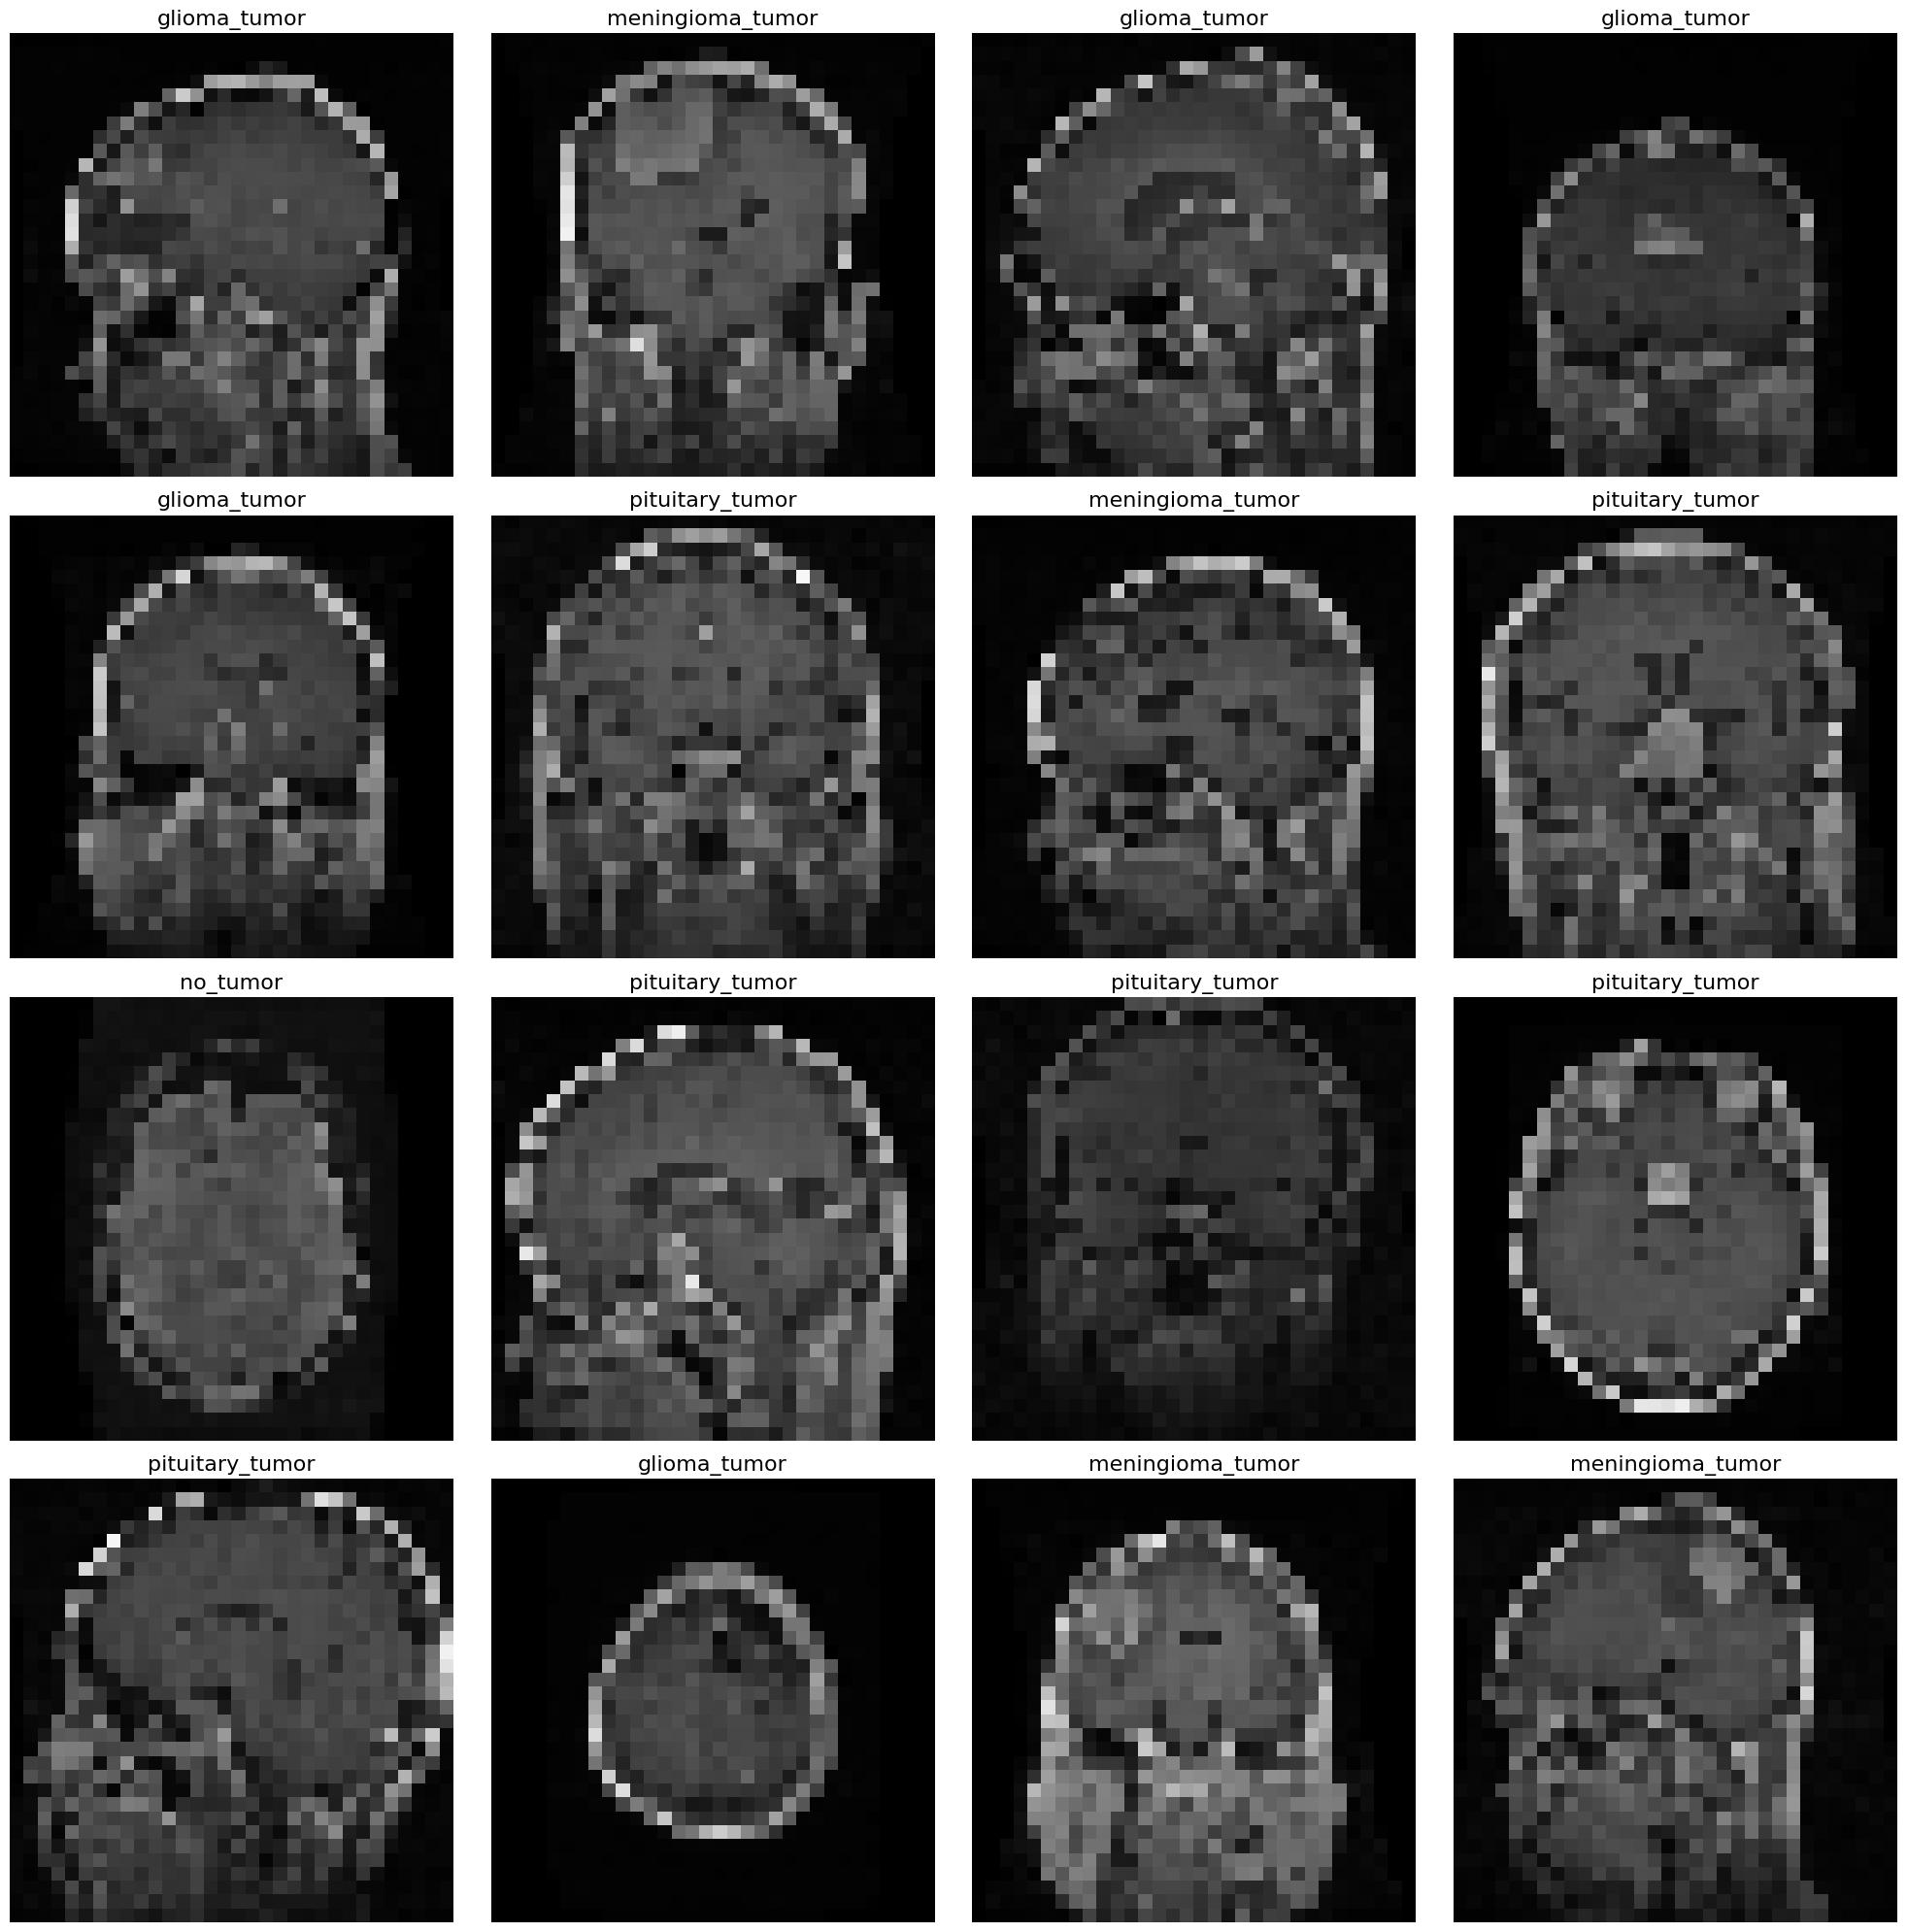

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
img_size = (32, 32)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [ ]:
epochs = 80   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/80
160/160 [==============================] - 490s 3s/step - loss: 2.4031 - accuracy: 0.5498 - val_loss: 2.8386 - val_accuracy: 0.3858
Epoch 2/80
160/160 [==============================] - 20s 126ms/step - loss: 0.7895 - accuracy: 0.6958 - val_loss: 2.7446 - val_accuracy: 0.4822
Epoch 3/80
160/160 [==============================] - 22s 136ms/step - loss: 0.6040 - accuracy: 0.7592 - val_loss: 2.4634 - val_accuracy: 0.5127
Epoch 4/80
160/160 [==============================] - 23s 147ms/step - loss: 0.4575 - accuracy: 0.8171 - val_loss: 2.7255 - val_accuracy: 0.5838
Epoch 5/80
160/160 [==============================] - 22s 135ms/step - loss: 0.4078 - accuracy: 0.8383 - val_loss: 2.4019 - val_accuracy: 0.6142
Epoch 6/80
160/160 [==============================] - 22s 135ms/step - loss: 0.2986 - accuracy: 0.8920 - val_loss: 2.4715 - val_accuracy: 0.5584
Epoch 7/80
160/160 [==============================] - 20s 124ms/step - loss: 0.2881 - accuracy: 0.8854 - val_loss: 2.3757 - val_accu

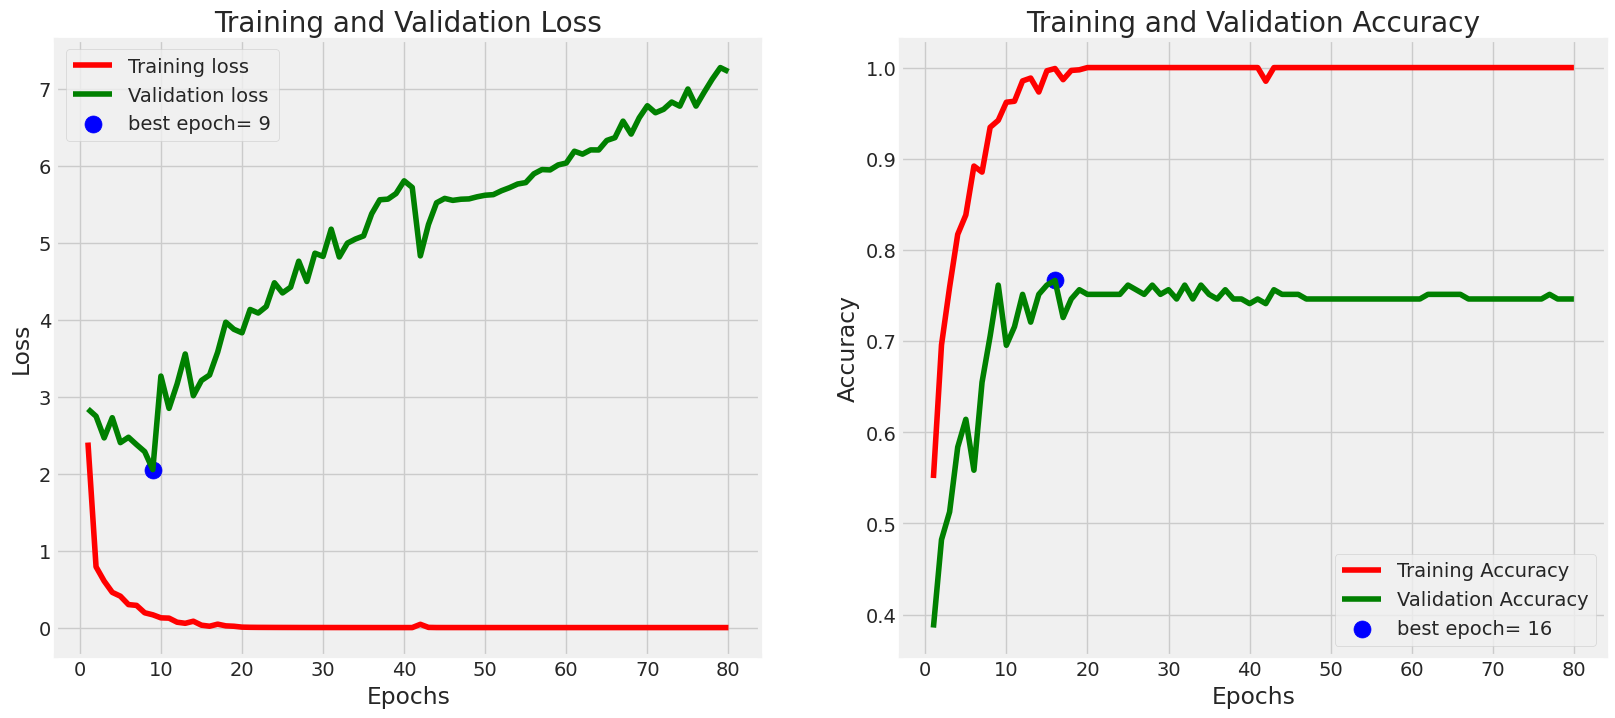

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 38s 4s/step - loss: 9.2621 - accuracy: 0.7208
Train Loss:  4.027030627185013e-06
Train Accuracy:  1.0
--------------------
Validation Loss:  7.2206830978393555
Validation Accuracy:  0.7461928725242615
--------------------
Test Loss:  9.262063980102539
Test Accuracy:  0.720812201499939


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

11/11 [==============================] - 1s 109ms/step


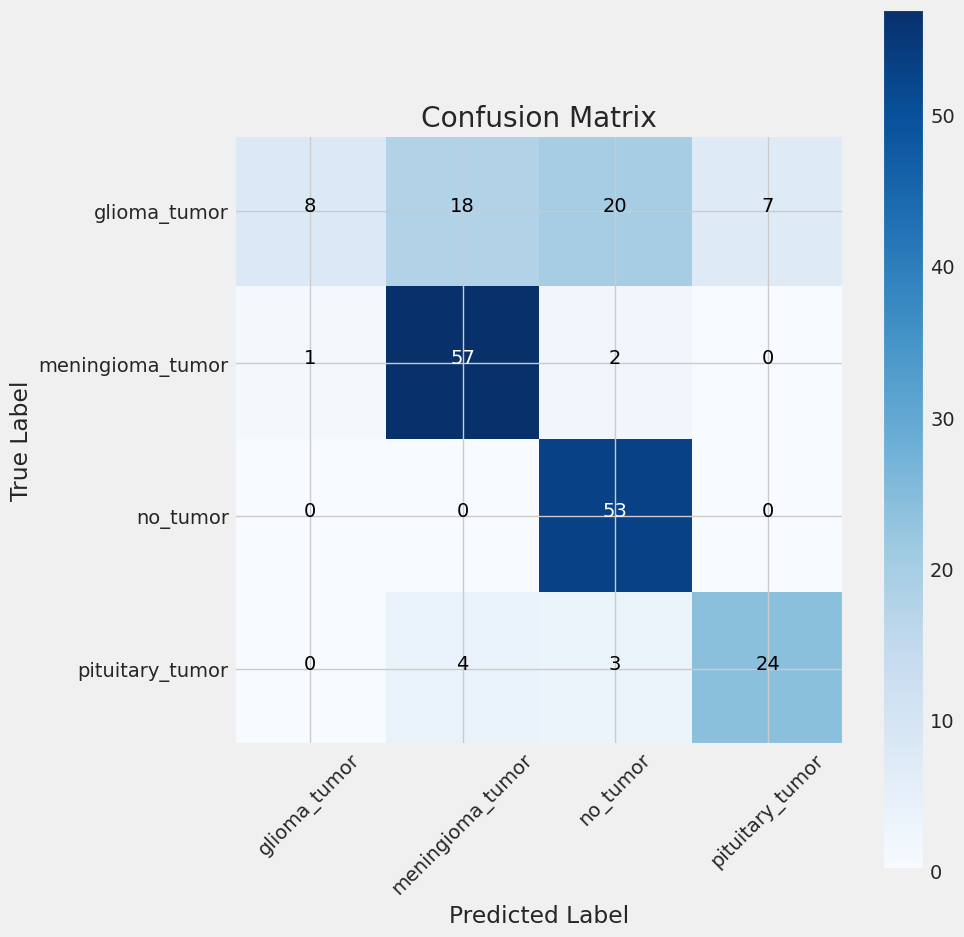

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.15      0.26        53
meningioma_tumor       0.72      0.95      0.82        60
        no_tumor       0.68      1.00      0.81        53
 pituitary_tumor       0.77      0.77      0.77        31

        accuracy                           0.72       197
       macro avg       0.77      0.72      0.67       197
    weighted avg       0.76      0.72      0.66       197



In [ ]:
#Save the model
model.save('Brain Tumor.h5')